In [1]:
import json
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
import datetime,time

In [2]:
path = "tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]
test_files =["sample0_period1.txt","sample0_period2.txt","sample0_period3.txt", \
             "sample1_period1.txt","sample1_period2.txt","sample1_period3.txt","sample2_period1.txt",\
             "sample2_period2.txt","sample2_period3.txt"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


In [3]:
def transfer_time(data_raw,time_type):
    
    pst_tz = pytz.timezone('America/Los_Angeles')
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','tweets','retweets','followers','mentioned',\
                                                'media','active','author','favourites_count','title'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)               

    # calculate hour index and minute index from time
    if time_type == 'hour':
        hour_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)  
            hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)                             
        pddata_raw['time'] = hour_accu
    elif time_type == 'minute':
        minu_accu = []
        for index, row in pddata_raw.iterrows():  
            p = datetime.datetime.fromtimestamp(row['time'], pst_tz)                    
            minu_accu.append((((p.month-1)*31+p.day-14)*24 + (p.hour-0))*12 + p.minute//5)             
        pddata_raw['time'] = minu_accu    
    else:
        print("Invalid time type")
        
    return pddata_raw

In [4]:
def generate_df(pddata_raw):
    """
    Create a new dataframe with desired form
    """
    df = pd.DataFrame([],columns=['time unit','tweets','retweets','followers sum','followers max',\
                                  'mentioned','media','active','author','favourites_count','title'])
    
    col = pddata_raw.columns.get_loc('time')
    df['time unit'] = range(int(pddata_raw.iloc[len(pddata_raw.index)-1,col] - pddata_raw.iloc[0,col]+1))

    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['media'] = pddata_raw.groupby("time")['media'].sum()
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    df['author'] = pddata_raw.groupby("time")['author'].nunique() # count number of not-repeating authors    
    df['favourites_count'] = pddata_raw.groupby("time")['favourites_count'].sum()
    df['title'] = pddata_raw.groupby("time")['title'].mean()
            
    # reset index of df
    df = df.fillna(0).reset_index(drop=True)
    
    return df

In [5]:
def parse_dataset(files):
    """
    Prase x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Prase y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r', encoding="utf-8") :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']             
            ment = len(a['tweet']['entities']['user_mentions'])        
            medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
            hist_tw = a['tweet']['user']["statuses_count"]
            hist_yr = a['tweet']['user']['created_at'][-4:]
            acti = hist_tw/(2015-float(hist_yr)+1) 
            auth = a['author']['name']
            favo = a['tweet']['user']['favourites_count']
            titl = len(a['title'])

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)    
            row_tmp.append(ment) 
            row_tmp.append(medi) 
            row_tmp.append(acti)  
            row_tmp.append(auth)
            row_tmp.append(favo)
            row_tmp.append(titl)

            # assign to 3 periods
            if citation_date < start_time:
                data_raw[0].append(row_tmp)
            elif citation_date < end_time:
                data_raw[1].append(row_tmp)
            else:
                data_raw[2].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_2 = transfer_time(data_raw[1],'minute')
    pddata_raw_2['time'] = pddata_raw_2['time'] - start_minute_idx
    pddata_raw_3 = transfer_time(data_raw[2],'hour')
    pddata_raw_3['time'] = pddata_raw_3['time'] - end_hour_idx - 1    
            
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,1].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    
    df_2 = generate_df(pddata_raw_2)
    df_y_2 = df_2.iloc[1:,1].reset_index(drop=True)
    df_2 = df_2[:len(df_y_2)]
   
    df_3 = generate_df(pddata_raw_3)
    df_y_3 = df_3.iloc[1:,1].reset_index(drop=True)
    df_3 = df_3[:len(df_y_3)]
    
    return (df_1.iloc[:,1:],df_y_1), (df_2.iloc[:,1:],df_y_2), (df_3.iloc[:,1:],df_y_3)

In [6]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [59]:
def six_times_window(df,df_y):
    m=df.shape[0]
    df_new= pd.DataFrame(np.zeros((m-4,10)),columns=['tweets','retweets','followers sum','followers max',\
                                  'mentioned','media','active','author','favourites_count','title'])
    df_y_new= pd.DataFrame(np.zeros((m-4)),columns=['num'])
    for i in range(m-4):
        
        for j in range(9):
            df_new.iloc[i,j]=(df.iloc[i,j]+df.iloc[i+1,j]+df.iloc[i+2,j]+df.iloc[i+3,j]+df.iloc[i+4,j])/5
        j=3
        df_new.iloc[i,3]=np.max([df.iloc[i,j],df.iloc[i+1,j],df.iloc[i+2,j],df.iloc[i+3,j],df.iloc[i+4,j]])
        j=6
        df_new.iloc[i,j]=(df.iloc[i,j]*df.iloc[i,7]+df.iloc[i+1,j]*df.iloc[i+1,7]+df.iloc[i+2,j]*df.iloc[i+2,7]+df.iloc[i+3,j]*df.iloc[i+3,7]+df.iloc[i+4,j]*df.iloc[i+4,7])/(df.iloc[i,7]+df.iloc[i+1,7]+df.iloc[i+2,7]+df.iloc[i+3,7]+df.iloc[i+4,7])
        j=9
        df_new.iloc[i,j]=(df.iloc[i,j]*df.iloc[i,0]+df.iloc[i+1,j]*df.iloc[i+1,0]+df.iloc[i+2,j]*df.iloc[i+2,0]+df.iloc[i+3,j]*df.iloc[i+3,0]+df.iloc[i+4,j]*df.iloc[i+4,0])/(df.iloc[i,0]+df.iloc[i+1,0]+df.iloc[i+2,0]+df.iloc[i+3,0]+df.iloc[i+4,0])
        df_y_new.iloc[i,0]=df_y.iloc[i+4]
    
    return df_new, df_y_new    

In [19]:

def parse_testdataset(path,files):
    """
    Parse x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Parse y of dataset as number of tweets in the next hour.
    """
    start_time = time.mktime(time.strptime("2015-02-01 08:00:00",'%Y-%m-%d %H:%M:%S'))
    end_time = time.mktime(time.strptime("2015-02-01 20:00:00",'%Y-%m-%d %H:%M:%S'))   

    start_hour_idx = ((2-1)*31+1-14)*24+8
    end_hour_idx = ((2-1)*31+1-14)*24+20
    start_minute_idx = (((2-1)*31+1-14)*24 + (8-0))*12 + 0//5    
        
    # extract raw features
    data_raw = [[],[],[]]
    for file in files:
        for line in open(path + file, 'r') :
            row_tmp = []
            a = json.loads(line)
            citation_date = a['citation_date']
            tweet = 1
            retweet = a['metrics']['citations']['total']
            foll = a['author']['followers']             
            ment = len(a['tweet']['entities']['user_mentions'])        
            medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
            hist_tw = a['tweet']['user']["statuses_count"]
            hist_yr = a['tweet']['user']['created_at'][-4:]
            acti = hist_tw/(2015-float(hist_yr)+1) 
            auth = a['author']['name']
            favo = a['tweet']['user']['favourites_count']
            titl = len(a['title'])

            # append to row_tmp
            row_tmp.append(citation_date)        
            row_tmp.append(tweet)        
            row_tmp.append(retweet)
            row_tmp.append(foll)    
            row_tmp.append(ment) 
            row_tmp.append(medi) 
            row_tmp.append(acti)  
            row_tmp.append(auth)
            row_tmp.append(favo)
            row_tmp.append(titl)

            # assign to 3 periods
            if citation_date < start_time:
                data_raw[0].append(row_tmp)
            elif citation_date < end_time:
                data_raw[1].append(row_tmp)
            else:
                data_raw[2].append(row_tmp)            

    # generate raw pandas dataframe
    pddata_raw_1 = transfer_time(data_raw[0],'hour')
    pddata_raw_1['time'] = pddata_raw_1['time'] - pddata_raw_1.loc[0,'time']
    
    pddata_raw_2 = transfer_time(data_raw[1],'minute')
#     pddata_raw_2['time'] = pddata_raw_2['time'] - start_minute_idx
    pddata_raw_2['time'] = pddata_raw_2['time'] - pddata_raw_2.loc[0,'time']

    pddata_raw_3 = transfer_time(data_raw[2],'hour')
#     pddata_raw_3['time'] = pddata_raw_3['time'] - end_hour_idx - 1    
    pddata_raw_3['time'] = pddata_raw_3['time'] - pddata_raw_3.loc[0,'time']
    print('1',pddata_raw_1)
    
    # generate df and df_y for each time slot
    df_1 = generate_df(pddata_raw_1)  
    df_y_1 = df_1.iloc[1:,1].reset_index(drop=True)
    df_1 = df_1[:len(df_y_1)]
    print('2',df_1)
    
    df_2 = generate_df(pddata_raw_2)
    df_y_2 = df_2.iloc[1:,1].reset_index(drop=True)
    df_2 = df_2[:len(df_y_2)]
   
    df_3 = generate_df(pddata_raw_3)
    df_y_3 = df_3.iloc[1:,1].reset_index(drop=True)
    df_3 = df_3[:len(df_y_3)]
    
    return (df_1.iloc[:,1:],df_y_1), (df_2.iloc[:,1:],df_y_2), (df_3.iloc[:,1:],df_y_3)

In [47]:
(dfo,dfo_y),(dfo_2,dfo_y_2),(dfo_3,dfo_y_3) = parse_dataset(files)

In [60]:
df, df_y  =six_times_window(dfo,dfo_y)
df_2, df_y_2  =six_times_window(dfo_2,dfo_y_2)
df_3, df_y_3  =six_times_window(dfo_3,dfo_y_3)

In [32]:
print(df.shape,df_y.shape,df_2.shape,df_y_2.shape,df_3.shape,df_y_3.shape)

(435, 10) (435, 1) (139, 10) (139, 1) (130, 10) (130, 1)


In [55]:
dfo[0:6]

,tweets,retweets,followers sum,followers max,mentioned,media,active,author,favourites_count,title
0,111,714,223405.0,41818.0,45,14,16495.717600,68,169019,107.738739
1,89,663,187317.0,19558.0,25,23,14668.183788,63,126515,114.955056
2,110,640,1657090.0,1362401.0,30,20,18070.444596,68,219997,118.100000
3,100,267,165256.0,19558.0,25,14,15166.468933,66,96787,118.460000
4,137,468,444858.0,65150.0,77,18,11300.612887,96,164014,111.883212
5,169,346,683834.0,104412.0,58,42,9554.832580,123,287280,109.940828


In [56]:
dfo_y[0:6]

0     89
1    110
2    100
3    137
4    169
5    215
Name: tweets, dtype: int64

In [57]:
df[0:2] 

,tweets,retweets,followers sum,followers max,mentioned,media,active,author,favourites_count,title
0,547.0,2752.0,2677926.0,1362401.0,202.0,89.0,14848.865359,361.0,776332.0,113.994516
1,605.0,2384.0,3138355.0,1362401.0,215.0,117.0,13014.365397,416.0,894593.0,114.009917


In [58]:
df_y[0:2]

,num
0,169.0
1,215.0


In [33]:
test_files_1 =["sample0_period1.txt","sample0_period2.txt","sample0_period3.txt"]
test_files_2 =["sample1_period1.txt","sample1_period2.txt","sample1_period3.txt"]
test_files_3 =["sample2_period1.txt","sample2_period2.txt","sample2_period3.txt"]

In [61]:
(df_test1,df_y_test1),(df_2_test1,df_y_2_test1),(df_3_test1,df_y_3_test1) = parse_testdataset(path,test_files_1)
(df_test2,df_y_test2),(df_2_test2,df_y_2_test2),(df_3_test2,df_y_3_test2) = parse_testdataset(path,test_files_2)
(df_test3,df_y_test3),(df_2_test3,df_y_2_test3),(df_3_test3,df_y_3_test3) = parse_testdataset(path,test_files_3)

1      time  tweets  retweets  followers  mentioned  media         active  \
0       0       1         1    98191.0          0      1    2715.428571   
1       0       1         1      158.0          0      0    2385.250000   
2       0       1         1      370.0          0      2     302.400000   
3       0       1         2     6549.0          3      0    1987.142857   
4       0       1         1      187.0          1      0    1324.000000   
5       0       1         1     1352.0          0      0    2804.500000   
6       0       1         1    18722.0          0      0     633.666667   
7       0       1         2     1427.0          1      0    2031.428571   
8       0       1         1      617.0          0      1     229.000000   
9       0       1         3      213.0          1      1     608.200000   
10      0       1         2      213.0          1      1     608.200000   
11      0       1         1     3331.0          1      0    3434.125000   
12      0       1      

1       time  tweets  retweets  followers  mentioned  media         active  \
0        0       1         1      387.0          0      0     145.000000   
1        0       1         1       96.0          0      1    7488.000000   
2        0       1         1     1768.0          0      0     924.000000   
3        0       1         1        0.0          0      0    1158.000000   
4        0       1         2    54469.0          1      1   14011.833333   
5        0       1         1      359.0          1      0     511.750000   
6        0       1         1      751.0          0      0     122.600000   
7        0       1         1        0.0          0      0    1159.000000   
8        0       1         1      572.0          0      0      78.333333   
9        0       1         1     4064.0          0      0    6412.000000   
10       0       1         1        9.0          0      0      13.000000   
11       0       1         1     3010.0          0      0    1691.000000   
12       0

1      time  tweets  retweets  followers  mentioned  media         active  \
0       0       1         1      160.0          0      0     126.000000   
1       0       1         1      135.0          0      0     404.750000   
2       0       1         1      547.0          1      0     335.500000   
3       0       1         1      123.0          1      0     168.750000   
4       0       1         1       15.0          0      0      14.000000   
5       0       1         1     1400.0          0      0    8654.000000   
6       0       1         1      249.0          0      0     704.000000   
7       0       1         1        2.0          0      0       4.000000   
8       0       1         1      175.0          0      0     470.714286   
9       0       1         1      381.0          2      0    2865.000000   
10      0       1         1       33.0          0      0      72.000000   
11      0       1         1        2.0          0      0       7.500000   
12      0       1      

In [62]:
df_test1, df_y_test1  =six_times_window(df_test1,df_y_test1)
df_2_test1, df_y_2_test1  =six_times_window(df_2_test1,df_y_2_test1)
df_3_test1, df_y_3_test1  =six_times_window(df_3_test1,df_y_3_test1)
df_test2, df_y_test2  =six_times_window(df_test2,df_y_test2)
df_2_test2, df_y_2_test2  =six_times_window(df_2_test2,df_y_2_test2)
df_3_test2, df_y_3_test2  =six_times_window(df_3_test2,df_y_3_test2)
df_test3, df_y_test3  =six_times_window(df_test3,df_y_test3)
df_2_test3, df_y_2_test3  =six_times_window(df_2_test3,df_y_2_test3)
df_3_test3, df_y_3_test3  =six_times_window(df_3_test3,df_y_3_test3)

In [63]:
reg = RandomForestRegressor(oob_score=True,n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
reg.fit(df,df_y)
pred = reg.predict(df)
pred1=reg.predict(df_test1)
pred2=reg.predict(df_test2)
pred3=reg.predict(df_test3)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [75]:
print(df_y_test1,df_y_test2,df_y_test3)
print(pred1,pred2,pred3)

     num
0  120.0      num
0  846.0     num
0  61.0
[508.89237475] [651.18824667] [581.18774148]


In [43]:
reg = RandomForestRegressor(oob_score=True,n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
reg.fit(df_2,df_y_2)
pred = reg.predict(df_2)
pred1=reg.predict(df_2_test1)
pred2=reg.predict(df_2_test2)
pred3=reg.predict(df_2_test3)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [44]:
print(df_y_2_test1,df_y_2_test2,df_y_2_test3)
print(pred1,pred2,pred3)

      num
0  1123.0      num
0  903.0     num
0  28.0
[10555.0317017] [5492.2012037] [549.39083333]


In [45]:
reg = RandomForestRegressor(oob_score=True,n_estimators=1800,max_depth=10,min_samples_leaf=1,min_samples_split=2, bootstrap=True,max_features='sqrt',random_state=42)
reg.fit(df_3,df_y_3)
pred = reg.predict(df_3)
pred1=reg.predict(df_3_test1)
pred2=reg.predict(df_3_test2)
pred3=reg.predict(df_3_test3)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [46]:
print(df_y_3_test1,df_y_3_test2,df_y_3_test3)
print(pred1,pred2,pred3)

    num
0  87.0     num
0  46.0     num
0  43.0
[62.94666667] [66.89222222] [67.55141077]


# GradientBoostingRegressor

# Neural Network

In [76]:
scaler = StandardScaler()
scaler.fit(df)
df_trans=scaler.transform(df)
reg = MLPRegressor(hidden_layer_sizes=(50,600,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df_trans,df_y)
pred = reg.predict(df_trans)
print("MSE=",mean_squared_error(df_y, pred))

F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MSE= 3935615.2016385505


In [77]:
pred1=reg.predict(scaler.transform(df_test1))
pred2=reg.predict(scaler.transform(df_test2))
pred3=reg.predict(scaler.transform(df_test3))
print(df_y_test1,df_y_test2,df_y_test3)
print(pred1,pred2,pred3)

     num
0  120.0      num
0  846.0     num
0  61.0
[815.42367993] [296.79283755] [256.69073654]


In [78]:
scaler = StandardScaler()
scaler.fit(df_2)
df_2_trans=scaler.transform(df_2)
reg = MLPRegressor(hidden_layer_sizes=(50,600,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(df_2_trans,df_y_2)
pred = reg.predict(df_2_trans)
print("MSE=",mean_squared_error(df_y_2, pred))
pred1=reg.predict(scaler.transform(df_2_test1))
pred2=reg.predict(scaler.transform(df_2_test2))
pred3=reg.predict(scaler.transform(df_2_test3))
print(df_y_2_test1,df_y_2_test2,df_y_2_test3)
print(pred1,pred2,pred3)

F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1316: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE= 33743118.10965791
      num
0  1123.0      num
0  903.0     num
0  28.0
[9085.7320654] [8762.86407745] [1721.38888915]


F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [94]:
df_y_2.iloc[0]

num    321.0
Name: 0, dtype: float64

In [95]:
pred[0]

1994.9289373057418

In [96]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

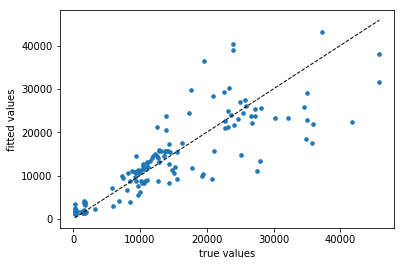

In [97]:
plot_recipe(df_y_2,pred)

In [98]:
scaler = StandardScaler()
scaler.fit(dfo_2)
dfo_2_trans=scaler.transform(dfo_2)
reg = MLPRegressor(hidden_layer_sizes=(50,600,300,),activation='relu', solver='adam', alpha=1e-5, random_state=42) 
reg.fit(dfo_2_trans,dfo_y_2)
pred = reg.predict(dfo_2_trans)
print("MSE=",mean_squared_error(dfo_y_2, pred))

F:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


MSE= 24966940.773291156


F:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


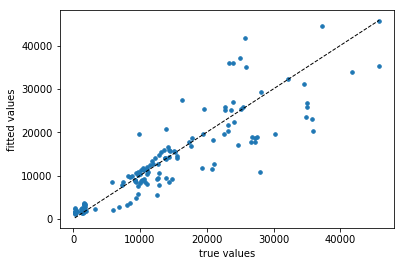

In [99]:
plot_recipe(dfo_y_2,pred)